<h1><h1>Crack detection on concrete images using pretrained ResNet-18, a deep convolution neural network (CNN) model, with pytorch </h1>

Author: Keshab Sapkota

## Abstract

In this work, I used pretrained ResNet-18 model to detect cracks on concrete images. The dataset contained 40000 RGB images of cracked and uncracked concrete surfaces which were saved in pytorch tensor format. The cracked concrete images or positive samples were labeled with '1', and uncracked images or negative samples were labeled with '0'. The Dataset class was constructed to set 30000 images for training and 10000 images for validation. The challenge associated with this dataset was that cracks could be confused with noise in the background texture, foreign objects, illumination, and irregularities such as exposure of jointing and finding. To solve this problem of cracks detection, I used Pre-trained ResNet-18 model which is a state of art convolutional neural network (CNN) model that is 18 layers deep and has beed trained with over 1 million images. ResNet-18 model for this project was prepared by adding a custom fully connected final hidden neural network layer and an feature extractor output layer on the pretrained convolution neural network layers. The fully connected layer was a linear classifier which contained 512 inputs matching with the output of CNN output. The output layer contained two outputs corresponding to cracked and uncracked concrete lables. The model was trained on train dataset with batch processing by minimizing crossEntropyLoss as loss function. The model performance was examined by validation dataset and accuracy of the model was calculated which is over 98%. Finally, first few misclassified samples were also indentified.



<h2>Table of Contents</h2>

1. [Download Data](#1.-Download-Data)
2. [Explore Data](#2.-Explore-Data)
3. [Dataset Class](#3.-Dataset-Class)
4. [Prepare a pre-trained ResNet-18 model](#4.-Prepare-a-pre-trained-ResNet-18-model)
5. [Train & Validate the Model](#5.-Train-&-Validate-the-Model)
6. [Find the misclassified samples](#6.-Find-the-misclassified-samples)
<hr>

## 1. Download Data

Download the dataset and unzip the files in your data directory. This project was completed in IBM Watson studio. Some of the following codes are specific to Watson studio.

In [1]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 
!unzip -q Positive_tensors.zip 

--2020-04-05 16:29:58--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘Positive_tensors.zip’

100%[====================================>] 2,598,656,062 49.5MB/s   in 54s    

2020-04-05 16:30:53 (45.6 MB/s) - ‘Positive_tensors.zip’ saved [2598656062/2598656062]



In [2]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

--2020-04-05 16:40:28--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

100%[====================================>] 2,111,408,108 42.4MB/s   in 45s    

2020-04-05 16:41:14 (44.6 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



Let's install torchvision.

In [3]:
!pip install torchvision

     |████████████████████████████████| 4.0MB 14.1MB/s eta 0:00:01
     |████████████████████████████████| 753.4MB 16kB/s s eta 0:00:01██▏                         | 146.3MB 32.4MB/s eta 0:00:192MB 33.4MB/s eta 0:00:18          | 342.1MB 41.9MB/s eta 0:00:10████████████████          | 518.3MB 51.5MB/s eta 0:00:05


The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.

In [4]:
# Follwing libraries are used here.
import torchvision.models as models
from torchvision import transforms
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pylab as plt
import numpy as np
import h5py
import os
import glob
torch.manual_seed(0)

## 2. Explore Data

Following code sets paths for positive (cracked concrete images) and negative files (uncracked concrete images)

In [5]:
#Paths of positive and negative files
directory="/home/dsxuser/work"
positive="Positive_tensors"
negative='Negative_tensors'

positive_file_path=os.path.join(directory,positive)
negative_file_path=os.path.join(directory,negative)
positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]

In [6]:
print(positive_files[0])
print(negative_files[0])

/home/dsxuser/work/Positive_tensors/14040.pt
/home/dsxuser/work/Negative_tensors/14040.pt


In [7]:
torch.load(positive_files[0])

tensor([[[1.3070, 1.3242, 1.3242,  ..., 1.1529, 1.2043, 1.2557],
         [1.3070, 1.3242, 1.3242,  ..., 1.1872, 1.2385, 1.2899],
         [1.3070, 1.3242, 1.3242,  ..., 1.1700, 1.2214, 1.2728],
         ...,
         [1.2214, 1.2557, 1.2043,  ..., 1.3584, 1.3584, 1.3584],
         [1.2214, 1.2557, 1.2043,  ..., 1.3242, 1.3242, 1.3242],
         [1.2214, 1.2557, 1.2043,  ..., 1.2899, 1.2899, 1.2899]],

        [[1.2556, 1.2731, 1.2731,  ..., 1.0805, 1.1331, 1.1856],
         [1.2556, 1.2731, 1.2731,  ..., 1.1155, 1.1681, 1.2206],
         [1.2556, 1.2731, 1.2731,  ..., 1.0980, 1.1506, 1.2031],
         ...,
         [1.1506, 1.1856, 1.1331,  ..., 1.3081, 1.3081, 1.3081],
         [1.1506, 1.1856, 1.1331,  ..., 1.2731, 1.2731, 1.2731],
         [1.1506, 1.1856, 1.1331,  ..., 1.2381, 1.2381, 1.2381]],

        [[1.1934, 1.2108, 1.2108,  ..., 1.0191, 1.0714, 1.1237],
         [1.1934, 1.2108, 1.2108,  ..., 1.0539, 1.1062, 1.1585],
         [1.1934, 1.2108, 1.2108,  ..., 1.0365, 1.0888, 1.

**Transform image data for the plot**

In [8]:
#Define transform function to get image data that can be plotted in plt.imshow

def transform(torch_image, isfile = False):
    
    #torch_image has shape of (3, xxx, xxx)
    if isfile == True:
        np_image = torch.load(torch_image).numpy()
    else:
        np_image = torch_image.numpy()
        
    d1, d2 = np_image.shape[1], np_image.shape[2]
    
    image = np.zeros([d1, d2, 3])
    for i, layer in enumerate(np_image):
        #transform data in the range [0,1]
        transformed = (layer - np.min(layer))/(np.max(layer)- np.min(layer))
        
        #Transform into shape (xxx, xxx, 3) which can be plotted by plt.imshow
        image[:, :, i] = transformed
        
    return(image)

**Plot images**

Positive files (crack on conceret)


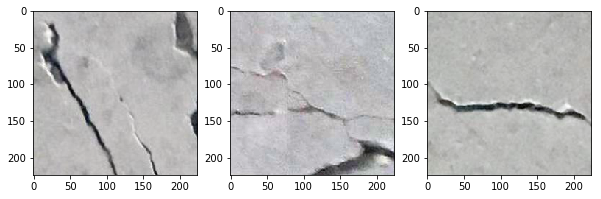

In [9]:
#Display positive files
f, ax = plt.subplots(1, 3, figsize = (10, 10))
print('Positive files (crack on conceret)')
for i in range(3):
    image = transform(positive_files[i], isfile = True)
    ax[i].imshow(image)

Negative files (no crack on concrete)


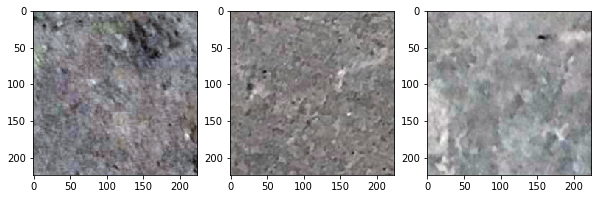

In [10]:
#Display negative files
f, ax = plt.subplots(1, 3, figsize = (10, 10))
print('Negative files (no crack on concrete)')
for i in range(3):
    image = transform(negative_files[i], isfile = True)
    ax[i].imshow(image)

<!--Empty Space for separating topics-->

## 3. Dataset Class

 Here Dataset class is constructed which defines training and validation datasets. The each dataset will have positive and negative samples alternately.

In [11]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/home/dsxuser/work"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


Next, let's create two dataset objects, one for the training data and one for the validation data.

In [12]:
# Training and Validation dataset objects

train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)

In [13]:
#Check a tensor from train_dataset, it should have image data and y label
train_dataset[0]

(tensor([[[1.3070, 1.3242, 1.3242,  ..., 1.1529, 1.2043, 1.2557],
          [1.3070, 1.3242, 1.3242,  ..., 1.1872, 1.2385, 1.2899],
          [1.3070, 1.3242, 1.3242,  ..., 1.1700, 1.2214, 1.2728],
          ...,
          [1.2214, 1.2557, 1.2043,  ..., 1.3584, 1.3584, 1.3584],
          [1.2214, 1.2557, 1.2043,  ..., 1.3242, 1.3242, 1.3242],
          [1.2214, 1.2557, 1.2043,  ..., 1.2899, 1.2899, 1.2899]],
 
         [[1.2556, 1.2731, 1.2731,  ..., 1.0805, 1.1331, 1.1856],
          [1.2556, 1.2731, 1.2731,  ..., 1.1155, 1.1681, 1.2206],
          [1.2556, 1.2731, 1.2731,  ..., 1.0980, 1.1506, 1.2031],
          ...,
          [1.1506, 1.1856, 1.1331,  ..., 1.3081, 1.3081, 1.3081],
          [1.1506, 1.1856, 1.1331,  ..., 1.2731, 1.2731, 1.2731],
          [1.1506, 1.1856, 1.1331,  ..., 1.2381, 1.2381, 1.2381]],
 
         [[1.1934, 1.2108, 1.2108,  ..., 1.0191, 1.0714, 1.1237],
          [1.1934, 1.2108, 1.2108,  ..., 1.0539, 1.1062, 1.1585],
          [1.1934, 1.2108, 1.2108,  ...,

In [14]:
#Check if the image data is of required shape and type
print(train_dataset[0][0].shape)
print(train_dataset[0][0].type())
torch.mean(torch.mean(train_dataset[0][0], axis = 1), axis = 1)

torch.Size([3, 224, 224])
torch.FloatTensor


tensor([1.1002, 1.0385, 0.9784])

Train images


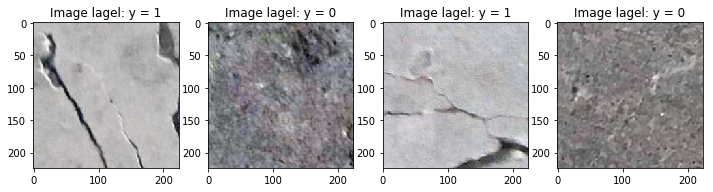

In [15]:
# Display train images, it should have positive and negative smaples alternately
f, ax = plt.subplots(1, 4, figsize = (12, 12))

print('Train images')
for i in range(4):
    image = transform(train_dataset[i][0], isfile = False)
    ax[i].imshow(image)
    ax[i].set_title('Image lagel: y = ' + str(train_dataset[i][1].item()))

Validation images


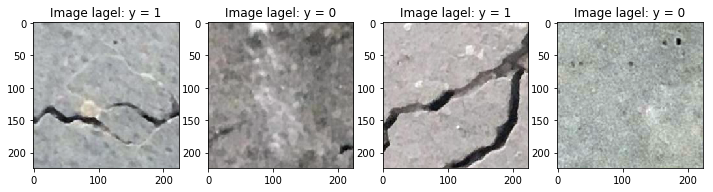

In [16]:
# Display validation images, it should also have positive and negative smaples alternately
f, ax = plt.subplots(1, 4, figsize = (12, 12))

print('Validation images')
for i in range(4):
    image = transform(validation_dataset[i][0], isfile = False)
    ax[i].imshow(image)
    ax[i].set_title('Image lagel: y = ' + str(validation_dataset[i][1].item()))

## 4. Prepare a pre-trained ResNet-18 model

**Load the pre-trained model ResNet-18**

In [17]:
#Load ResNet-18 model
model = models.resnet18(pretrained = True)

#Normalizing parameters for 3 (RGB) layers, these values are obtained from ResNet-18 model
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

#Normalize data
composed = transforms.Compose([transforms.Normalize(mean, std)])
train_dataset = Dataset(transform = composed, train = True)
validation_dataset = Dataset(transform = composed, train = False)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/dsxuser/.cache/torch/checkpoints/resnet18-5c106cde.pth


Since this model is pretrained, we don't want to train the weights in CNN layers. So, we set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the CNN parameters will not be affected by training.

In [18]:
for param in model.parameters():
    param.requires_grad = False

**Customize output layer**

The fully connected layer of ResNet-18 has 512 inputs from hidden CNN layers. ResNet-18 is used to classify 1000 different objects; as a result, the last layer has 1000 output i.e. it has 512 x 1000 fully connected neurons. Here, this fully connected layer is replaced by customized layer that has 512 inputs and 2 outputs.

In [19]:
# Custom fully connected layer
model.fc = nn.Linear(512, 2)

Let's see how is our ResNet-18 model looks like

In [20]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 5. Train & Validate the Model

**Create a cross entropy criterion function**

In [21]:
# The loss function
criterion = nn.CrossEntropyLoss()

**Data loader with batch of 100 samples**: Create a training loader and validation loader object, the batch size should have 100 samples each.

In [22]:
train_loader = DataLoader(dataset = train_dataset, batch_size=100)
validation_loader = DataLoader(dataset = validation_dataset, batch_size=100)

**Optimizer**

In [23]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

**Training for just one epoch (it takes more than 30 minuts!).  Accuracy is calculated on the validation data.**

In [24]:
n_epochs=1
loss_list=[]
N_test=len(validation_dataset)

start_time = time.time()

for epoch in range(n_epochs):
    for x, y in train_loader:

        model.train() 
        #clear gradient
        optimizer.zero_grad()         
        #make a prediction 
        yhat = model(x)
        # calculate loss 
        loss = criterion(yhat, y)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
        loss_list.append(loss.data)
        
    correct=0
    for x_test, y_test in validation_loader:
        # set model to eval 
        model.eval()
        #make a prediction 
        z = model(x_test)
        #find max indices
        _, yhat = torch.max(z, axis = 1)
       
        #Calculate misclassified  samples in mini-batch (100 samples) 
        correct += (yhat==y_test).sum().item()
   
    accuracy=correct/N_test
    
end_time = time.time()    

print('Time taken to complete: ', (end_time - start_time)/60, ' minutes')
print('Accuracy of the model: ', accuracy)

Time taken to complete:  46.31671082178752  minutes
Accuracy of the model:  0.995


**Loss plot**

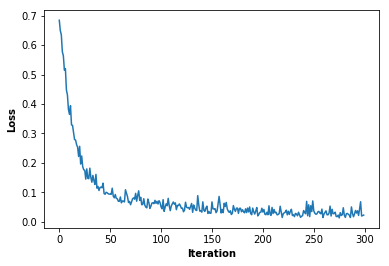

In [25]:
#Loss vs batch iteration of training data
plt.plot(loss_list)
plt.xlabel("Iteration", fontweight = 'bold')
plt.ylabel("Loss", fontweight = 'bold')
plt.show()

## 6. Find the misclassified samples

<b>Identify the first four misclassified samples using the validation data:</b>

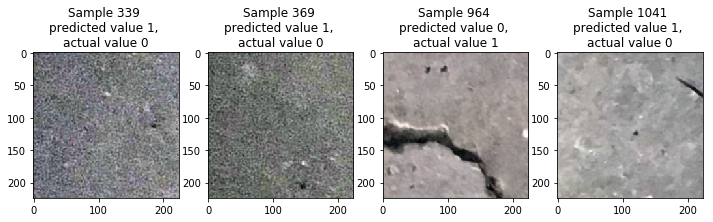

In [26]:
f, ax = plt.subplots(1, 4, figsize = (12, 12))

n = 0
for i, (x_val, y_val) in enumerate(validation_loader):
        #make a prediction 
        z = model(x_val)
        #find max 
        _, yhat = torch.max(z, axis = 1)
        
        missed_indices = np.where(yhat != y_val)[0]
        
        #Plot missed images
        for ind in missed_indices:
            n += 1
            title = 'Sample {} \npredicted value {}, \nactual value {}'.\
                  format(ind + 100*i, yhat[ind], y_val[ind])
            image = transform(x_val[ind], isfile = False)
            ax[n-1].imshow(image)
            ax[n-1].set_title(title)
            if n >= 4:
                break
        if n >= 4:
            break